In [8]:
import numpy as np
import matplotlib.pyplot as plt 
import xarray as xr
import gcsfs

## Generate NetCDF file from vtu files stores in GCS

Current netcdf stored on GCS

In [9]:
#%run ./netcdf_from_vtu.ipynb   #toil
#datacomb = vtu_transform()

fs = gcsfs.GCSFileSystem(project='ldeo-glaciology')
fullrun = fs.open('ldeo-glaciology/elmer_janie/netcdf_files/full_run.nc')
datacomb = xr.open_dataset(fullrun)

### Creates xarray with dimensions in x,y,t.

This is an unstructured grid so the logical dimensions (x,y) also need to be used to find the xvalues and yvalues of the gridpoints - the coordinates xvals and yvals.

Each t is a 10 year time step, which we assign to the 'years' coordinate 

In [10]:
datacomb = datacomb.assign_coords(years = (datacomb.t * 10))
datacomb

<xarray.Dataset>
Dimensions:  (t: 120, xnode: 1001, ynode: 31)
Coordinates:
    yvals    (t, ynode, xnode) float64 ...
    xvals    (t, ynode, xnode) float64 ...
    years    (t) int64 0 10 20 30 40 50 60 ... 1140 1150 1160 1170 1180 1190
Dimensions without coordinates: t, xnode, ynode
Data variables:
    vel_x    (t, ynode, xnode) float64 ...
    vel_y    (t, ynode, xnode) float64 ...

### Question 1: How does the surface of this ice model evolve?

The surface is a 1D line. In the model we change parameters of accumulation and flux, affecting the way the surace profile behaves.



Text(0, 0.5, 'yvals (m)')

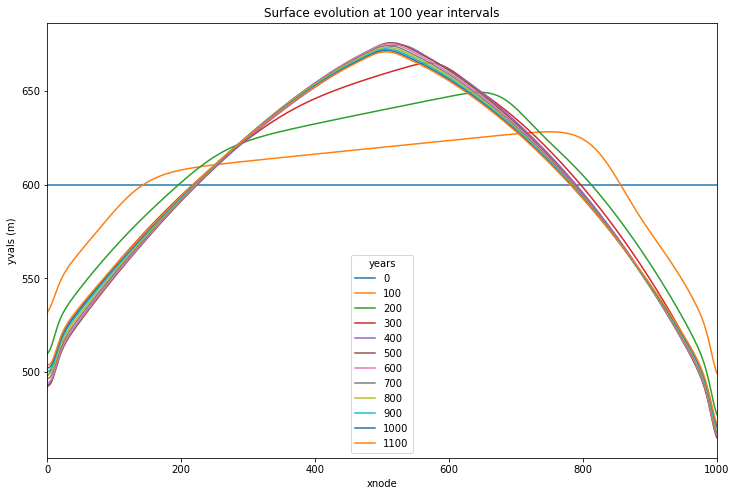

In [18]:
plt.figure(figsize = [12,8])

datacomb.sel(t= np.arange(0,120,10),ynode = (datacomb.ynode.shape[0] - 1)).yvals.plot(hue='years');
plt.xlim([0,1000])
plt.title('Surface evolution at 100 year intervals')
plt.ylabel('yvals (m)')

### Analyze the surface numerically:

I am using finite differences to calculate 1st and 2nd derivatives of each surface profile. 

In [ ]:
#surfder = surface_deriv(datacomb)

In [20]:
surfrun = fs.open('ldeo-glaciology/elmer_janie/netcdf_files/surfder.nc')
surfder = xr.open_dataset(surfrun)

### Example Analysis of One Time Slice

We are interested in the behaviour around the peak so we cut off the boundary effects

In [21]:
surf_narrow = surfder.sel(xnode = slice(400,601))
singleslice = surf_narrow.sel(t = 40)
surf_narrow

<xarray.Dataset>
Dimensions:  (t: 120, xnode: 201)
Coordinates:
    xvals    (t, xnode) float64 ...
    years    (t) int64 ...
Dimensions without coordinates: t, xnode
Data variables:
    yvals    (t, xnode) float64 ...
    dy       (t, xnode) float64 ...
    dy2      (t, xnode) float64 ...

Calculate inflection points and peak point.

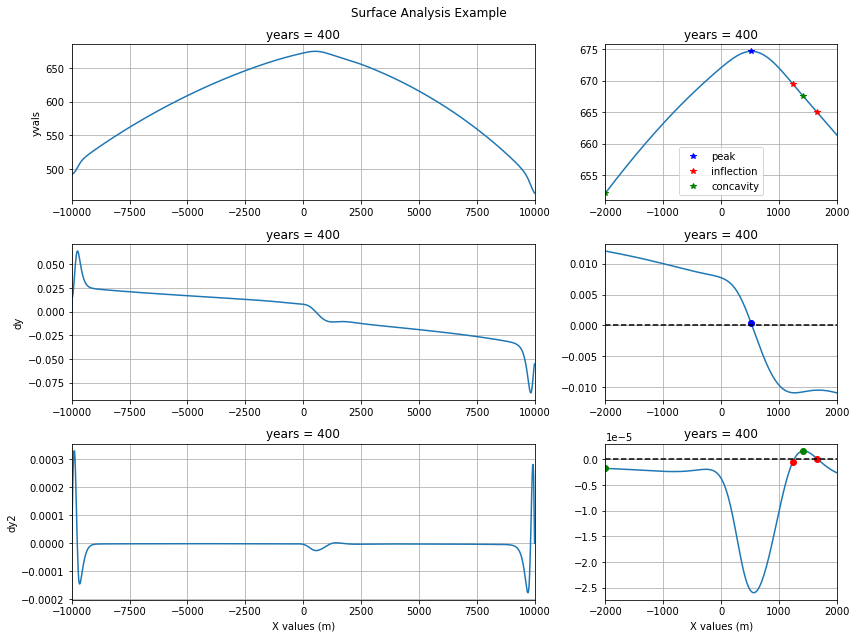

In [25]:

singleslice = surf_narrow.sel(t = 40)
peakind = 0
inflind = []
L = singleslice.dy2.shape[0]

#inflection points and peak
for i in range(L-1):
    if singleslice.dy[i]*singleslice.dy[i+1] < 0:
        peakind = i
    if singleslice.dy2[i]*singleslice.dy2[i+1] < 0:
        inflind.append(i)
#maximum concavity
c_l = singleslice.dy2[0:peakind].argmax()
c_r = singleslice.dy2[peakind:].argmax() + peakind

fig, ax = plt.subplots(ncols = 2,nrows = 3, figsize = [12,9],gridspec_kw={'width_ratios': [2, 1]})
surfder.yvals.sel(t = 40).plot(ax = ax[0,0],x = 'xvals')
surfder.dy.sel(t = 40).plot(ax = ax[1,0],x = 'xvals')
surfder.dy2.sel(t = 40).plot(ax = ax[2,0],x = 'xvals')
for x in range(3):
    ax[x,0].set_xlim([-10000,10000])
    ax[x,0].set_xlabel('')
    ax[x,0].grid()
#ax[0,0].set_title('Surface Analysis Example')
ax[2,0].set_xlabel('X values (m)')

singleslice.yvals.plot(ax = ax[0,1],x= 'xvals')
ax[0,1].plot(singleslice.xvals[peakind],singleslice.yvals[peakind], 'b*',label = 'peak')
ax[0,1].plot(singleslice.xvals[inflind],singleslice.yvals[inflind], 'r*', label = 'inflection')
ax[0,1].plot(singleslice.xvals[[c_l,c_r]],singleslice.yvals[[c_l,c_r]], 'g*', label = 'concavity')

singleslice.dy.plot(ax = ax[1,1],x= 'xvals')
ax[1,1].plot(singleslice.xvals[peakind],singleslice.dy[peakind], 'bo')
ax[1,1].plot([-2000,2000],[0,0], 'k--')

singleslice.dy2.plot(ax = ax[2,1],x= 'xvals')
ax[2,1].plot(singleslice.xvals[inflind],singleslice.dy2[inflind], 'ro')
ax[2,1].plot(singleslice.xvals[[c_l,c_r]],singleslice.dy2[[c_l,c_r]], 'go')
ax[2,1].plot([-2000,2000],[0,0], 'k--')

for x in range(3):
    ax[x,1].set_xlim([-2000,2000])
    ax[x,1].set_xlabel('')
    ax[x,1].set_ylabel('')
    
    ax[x,1].grid()
ax[2,1].set_xlabel('X values (m)')
ax[0,1].legend(loc = 'lower center')
fig.suptitle('Surface Analysis Example')
plt.tight_layout()

## Same analysis for all time steps
(This takes a minute or two so I have pre-processed them)

In [2]:
def surf_analyze(dataset, start_idx):
    T = dataset.t.shape[0]
    
    peakarr = []
    inflarr = []
    concarr = [] 
    for k in range(start_idx,dataset.t.shape[0]):
        print(k)
        singleslice = dataset.sel(t = k)
        peakind = 0
        inflind = []
        L = singleslice.dy2.shape[0]

        for i in range(L-1):
            if singleslice.dy[i]*singleslice.dy[i+1] < 0:
                peakind = i
            if singleslice.dy2[i]*singleslice.dy2[i+1] < 0:
                inflind.append(i)
        c_l = singleslice.dy2[0:peakind].argmax()
        c_r = singleslice.dy2[peakind:].argmax() + peakind


        peakarr.append(datacomb.sel(t = k, xnode = peakind))

        #variable number of inflection points (max 4)
        inflset = datacomb.sel(t = k, xnode = inflind)
        l = 4 - len(inflind)
        print(l)
        if l > 0:
            fill = xr.full_like(inflset.sel(xnode = slice(0,l)),np.nan)
            inflsetfil = xr.concat([inflset,fill],dim = 'xnode')
            inflarr.append(inflsetfil)
        else:
            inflarr.append(inflset)
            
    peakdat = xr.concat(peakarr, dim='t')
    concdat = xr.concat(concarr, dim='t')
    infldat = xr.concat(inflarr,dim='t')
    return peakdat,concdat,infldat

### Analysis over time


Uncomment below to generate these in the notebook

In [ ]:
#peakdat,concdat,inflind = surf_analyze(surfder.sel(xnode = slice(100,901)))

Uncomment below to open pre-processed files from GCS

In [11]:
peakrun = fs.open('ldeo-glaciology/elmer_janie/netcdf_files/peak_vals.nc')
peakdat = xr.open_dataset(peakrun)

inflrun = fs.open('ldeo-glaciology/elmer_janie/netcdf_files/infl_vals.nc')
infldat = xr.open_dataset(inflrun)

concrun = fs.open('ldeo-glaciology/elmer_janie/netcdf_files/conc_vals.nc')
concdat = xr.open_dataset(concrun)

Text(0.5, 1.0, 'Evolution of Surface Points')

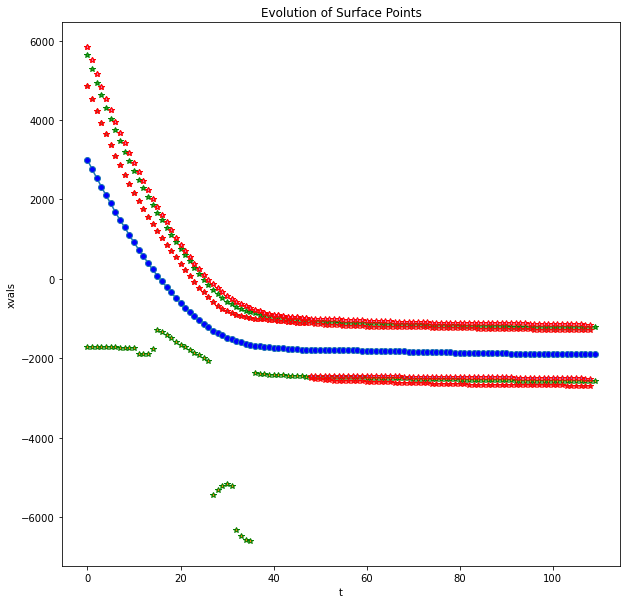

In [13]:
fig,ax = plt.subplots(figsize = [10,10])
peakdat.sel(ynode = (peakdat.ynode.shape[0] - 1)).xvals.plot(marker = 'o', markerfacecolor = 'blue', ax = ax, label ='Peak Value')

gsc = concdat.sel(ynode = (concdat.ynode.shape[0] - 1)).groupby('xnode')

for gname, gp in gsc:
    gp.xvals.plot(marker = '*',linestyle='None',markeredgecolor = 'green', ax = ax)

gsi = infldat.sel(ynode = (concdat.ynode.shape[0] - 1)).groupby('xnode')
for gname, gp in gsi:
    gp.xvals.plot(marker = '*',linestyle='None',markeredgecolor = 'red', ax = ax)

plt.title('Evolution of Surface Points')

### Question 2: What is happening to the internal velocity?

In [23]:
data_nb = datacomb.sel(xnode = slice(200,801))
data_nb

<xarray.Dataset>
Dimensions:  (t: 120, xnode: 601, ynode: 31)
Coordinates:
    yvals    (t, ynode, xnode) float64 ...
    xvals    (t, ynode, xnode) float64 ...
    years    (t) int64 0 10 20 30 40 50 60 ... 1140 1150 1160 1170 1180 1190
Dimensions without coordinates: t, xnode, ynode
Data variables:
    vel_x    (t, ynode, xnode) float64 ...
    vel_y    (t, ynode, xnode) float64 ...

### Horizontal Velocity

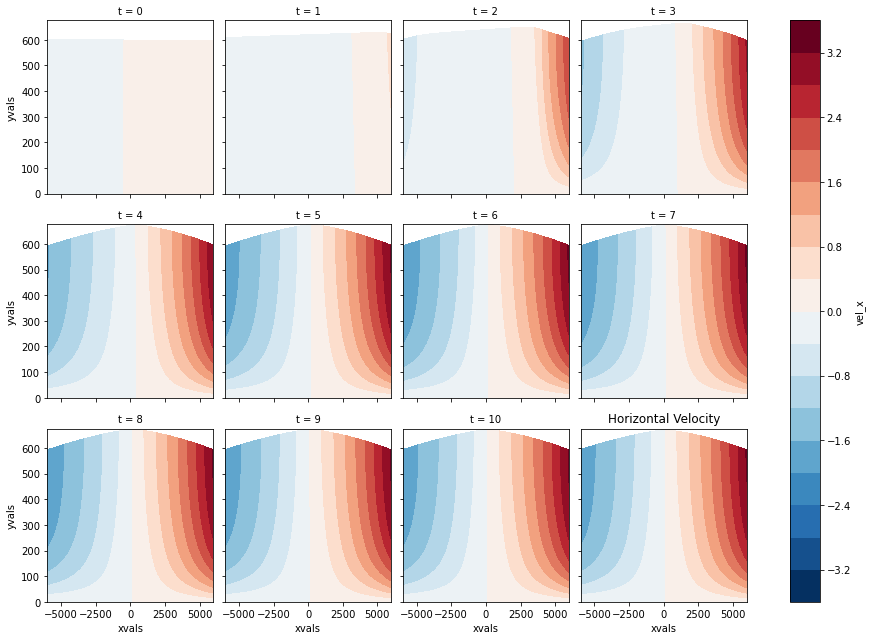

In [25]:
data_nb.sel(t = np.arange(0,120,10)).vel_x.plot.contourf(x = 'xvals', y = 'yvals',
    col = 't', col_wrap = 4, levels = 20
)
plt.title('Horizontal Velocity');

#### Vertical Velocity

Text(0.5, 1.0, 'Vertical Velocty')

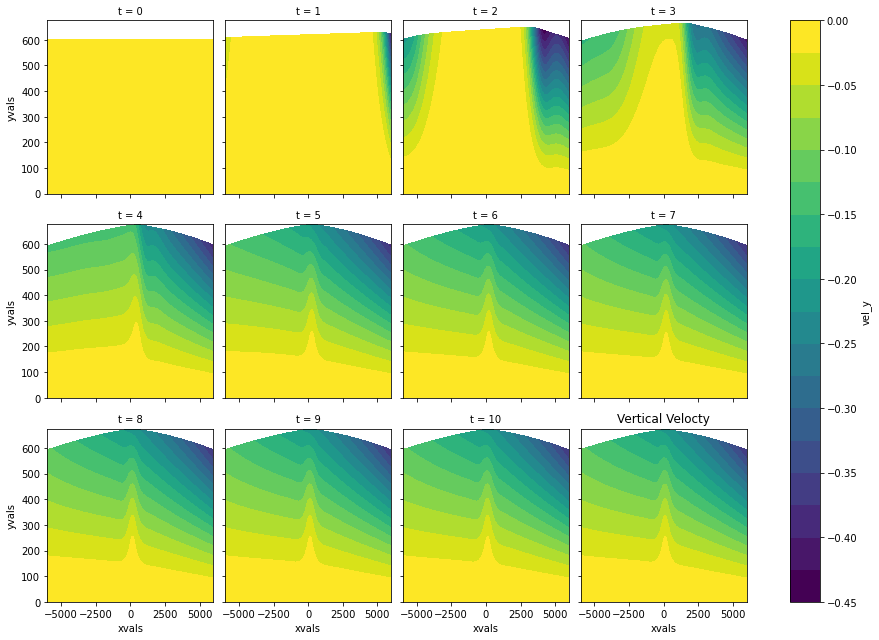

In [26]:
data_nb.sel(t = np.arange(0,120,10)).vel_y.plot.contourf(x = 'xvals', y = 'yvals',
    col = 't', col_wrap = 4, levels = 20
)
plt.title('Vertical Velocty');